In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.warnings.filterwarnings('ignore')

## Wczytywanie i inspekcja danych danych

In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')

### Wybrane cechy

#### Ilościowe:
* w6_q21c_year - w którym roku po raz pierwszy zamieszkali ze sobą
* year_fraction_met - rok poznania z uwzględnieniem miesiąca jako ułamka

### Jakościowe:
* hcm2017q24_btwn_I_neighbor - czy są sąsiadami
* w6_otherdate_all - czy w zeszłym roku poznał(a) kogoś poza partnerem

In [3]:
cat_features = ['hcm2017q24_btwn_I_neighbor', 'w6_otherdate_all']
cont_features = ['w6_q21c_year', 'year_fraction_met']
label = 'S1'

## Transformowanie danych

Podstawowe transformowanie danych:
* zamiana wektora y na wektor 0/1 (0 - małżeństwo, 1 - brak małżeństwa)
* zamiana cech kategorycznych na one hot encoding
* usunięcie niedozwolonych przez XGBooost znaków z nazw cech

Sprawdzamy też, czy po usunięciu NaN nie zostało za mało danych.

In [4]:
data = data[cat_features+cont_features+[label]].dropna()
print("Data left: " + str(len(data)))
X = data[cat_features+cont_features].copy()
y = data[label].cat.codes

Data left: 2566


In [5]:
# Convert continuous features to numerics
for cont_feature in cont_features:
    X[cont_feature] = pd.to_numeric(X[cont_feature])

def convert_to_dummies(X):
    with_dummies = pd.get_dummies(X)
    for character in ['[', ']', '<']:
        with_dummies.columns = with_dummies.columns.str.replace(character, '')
    with_dummies = with_dummies[sorted(with_dummies.columns.to_list())]
    return with_dummies

with_dummies = convert_to_dummies(X)

## Trening

Do treningu używam klasyfikatora XGB z domyślnymi parametrami.

In [6]:
# XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(with_dummies, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [8]:
# SVM model
svm_model = SVC(probability = True)
svm_model.fit(with_dummies, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
xgb_loss = 1.0-accuracy_score(xgb_model.predict(with_dummies), y)
svm_loss = 1.0-accuracy_score(svm_model.predict(with_dummies), y)

print("Loss of XGB model: "+str(xgb_loss))
print("Loss of SVM model: "+str(svm_loss))

Loss of XGB model: 0.18628215120810598
Loss of SVM model: 0.19134840218238502


## Ważność zmiennej

In [10]:
def feature_loss(model, X, y, feature_name):
    X[feature_name] = np.random.permutation(X[feature_name])
    with_dummies = convert_to_dummies(X)
    return 1.0-model.score(with_dummies, y)

def get_feature_importance(model, X, y):
    feature_importance = []

    for feature_name in X.columns:
        feature_importance.append((feature_loss(model, X.copy(), y, feature_name), feature_name))
  
    feature_importance.sort()
    return feature_importance

(0.18628215120810598, 0.2905300077942323)

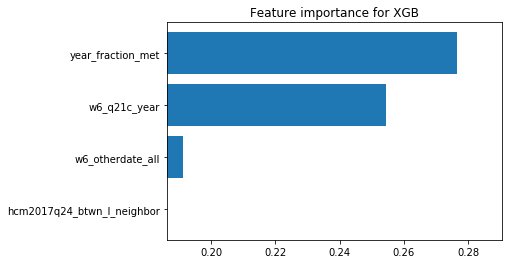

In [11]:
feature_importance = get_feature_importance(xgb_model, X.copy(), y)
plt.barh([x[1] for x in feature_importance], [x[0] for x in feature_importance])
plt.title("Feature importance for XGB")
plt.xlim(left=xgb_loss)

(0.19134840218238502, 0.2745713172252533)

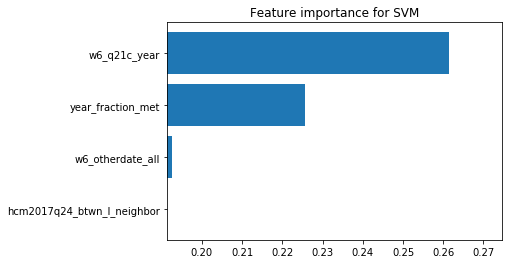

In [12]:
feature_importance = get_feature_importance(svm_model, X.copy(), y)
plt.barh([x[1] for x in feature_importance], [x[0] for x in feature_importance])
plt.title("Feature importance for SVM")
plt.xlim(left=svm_loss)

W modelu XGBoost cecha year_fraction_met jest wyraźnie istotniejsza niż w modelu SVM.

Pozostałe cechy wykazują podobne zachowania w obu modelach.

### Wykres PDP dla cechy year_fraction_met

In [13]:
N_POINTS = 100
def draw_pd_plot(model, X, feature_name, model_name):
    xs = np.linspace(X[feature_name].min(), X[feature_name].max(), N_POINTS)
    ys = []
    for x in xs:
        X[feature_name] = x
        ys.append(model.predict_proba(X)[:, 0].mean())
        
    plt.title("PDP plot for "+model_name)
    plt.xlabel(feature_name)
    plt.ylabel("Probability of getting married")
    plt.plot(xs, ys)

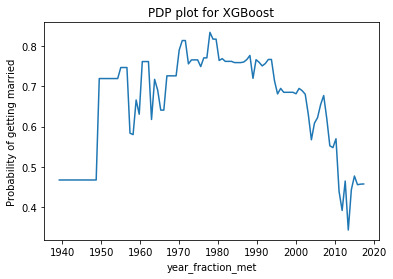

In [14]:
draw_pd_plot(xgb_model, with_dummies.copy(), 'year_fraction_met', 'XGBoost')

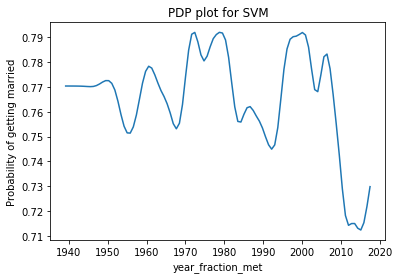

In [15]:
draw_pd_plot(svm_model, with_dummies.copy(), 'year_fraction_met', 'SVM')

Krzywa wygenerowana dla SVM jest bardziej gładka niż ta wygenerowana dla XGBoosta. Wynika to najprawdopodobnij z faktu, że XGB jest modelem opartym na drzewach, a SVM jako domyślnego kernela używa RBF, które z natury są bardziej gładkie. <br />
Dla krzywej XGBoosta widać ostry spadek dla lat < 1950. Wynika on z małej liczby przykładów (w tym przypadku SVM lepiej sobie z tym poradził):

In [16]:
print("Liczba par z year_fraction_met < 1950: " + str(len(X[X['year_fraction_met'] < 1950])))

Liczba par z year_fraction_met < 1950: 9


Dodatkowo widać na wykresie SVM nagły spadek pomiędzy latami 1980-1990. Nie udało mi się ustalić przyczyny tego, jednak podejżewam, że wynika to z kształtu funkcji kernela w SVM.